In [ ]:
import os
from pathlib import Path
if "FRIGUS_DATADIR_ROOT" not in os.environ:
    os.environ["FRIGUS_DATADIR_ROOT"] = f"{os.environ['CONDA_PREFIX']}/data"
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy import constants as const
from astropy import units as u

import LWphotorates as lwpr
from LWphotorates.utils import nu2lambda, lambda2nu, spec_nu2lambda, spec_lambda2nu
# from LWphotorates.utils import convert_energy_cm2ev, convert_energy_ev2cm, convert_energy_cm2k, convert_energy_k2cm
from LWphotorates.utils import generate_blackbody_spectrum, generate_flat_spectrum

plt.style.use(Path(lwpr.__file__) / "default.mplstyle")

In [2]:
gas_density_for_tests = 1e0 * u.cm**(-3)
gas_temperature_for_tests = 1e2 * u.K

# example: SLUG

In [ ]:
data_example_path = Path(lwpr.__file__).parent / "inputdata" / "example_spectra" / "exampleSlug.txt"
data_example = np.loadtxt(data_example_path)

age_stars_SEDs = np.logspace(6, 9, 61)
wl_SEDs = data_example[0] * u.angstrom
spectra_SEDs = data_example[1:] * u.erg / u.s / u.angstrom

freq_SEDs = lambda2nu(wl_SEDs)
energy_SEDs = const.h.to(u.eV / u.Hz) * freq_SEDs

Text(0, 0.5, '$L_\\nu$  [$\\mathrm{erg} \\ \\mathrm{s}^{-1} \\ \\mathrm{\\AA}^{-1}$]')

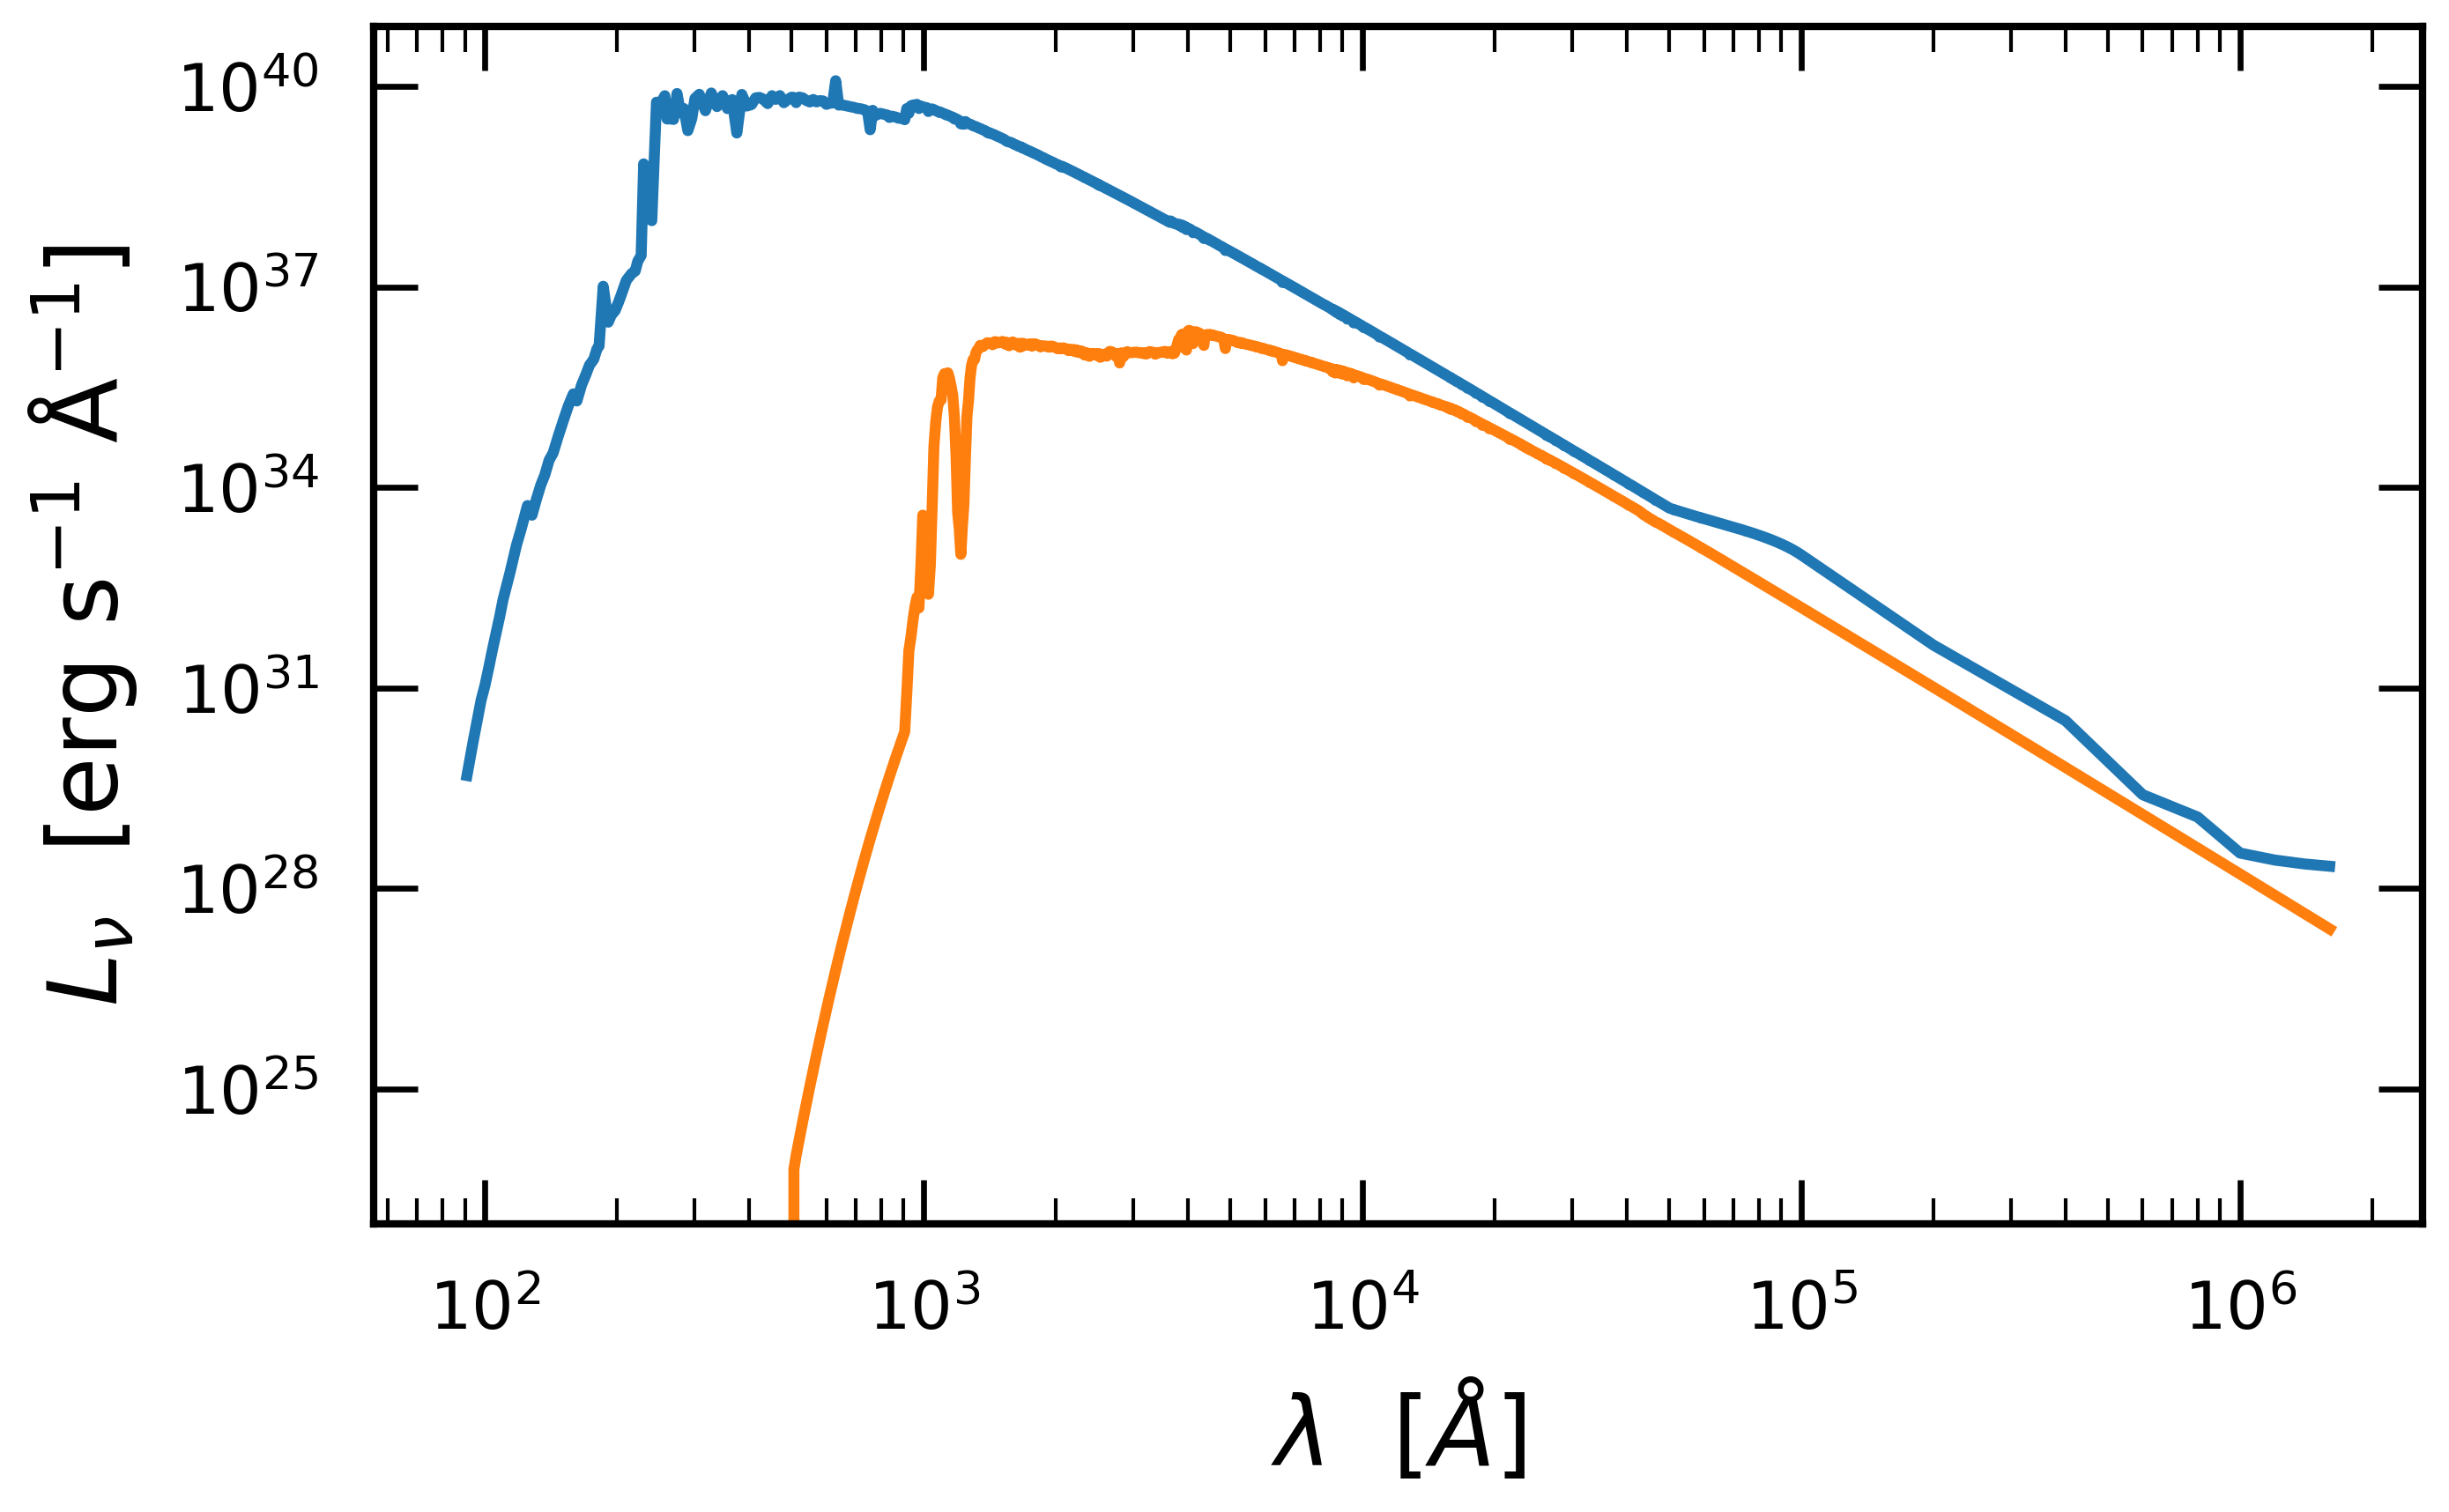

In [13]:
fig, ax = plt.subplots()
ax.plot(wl_SEDs, spectra_SEDs[0], lw=3)
ax.plot(wl_SEDs, spectra_SEDs[-1], lw=3)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\lambda$  [$\AA$]")
ax.set_ylabel(r"$L_\nu$  [$\mathrm{erg} \ \mathrm{s}^{-1} \ \mathrm{\AA}^{-1}$]")

Text(0, 0.5, '$L_\\nu$  [$\\mathrm{erg} \\ \\mathrm{s}^{-1} \\ \\mathrm{Hz}^{-1}$]')

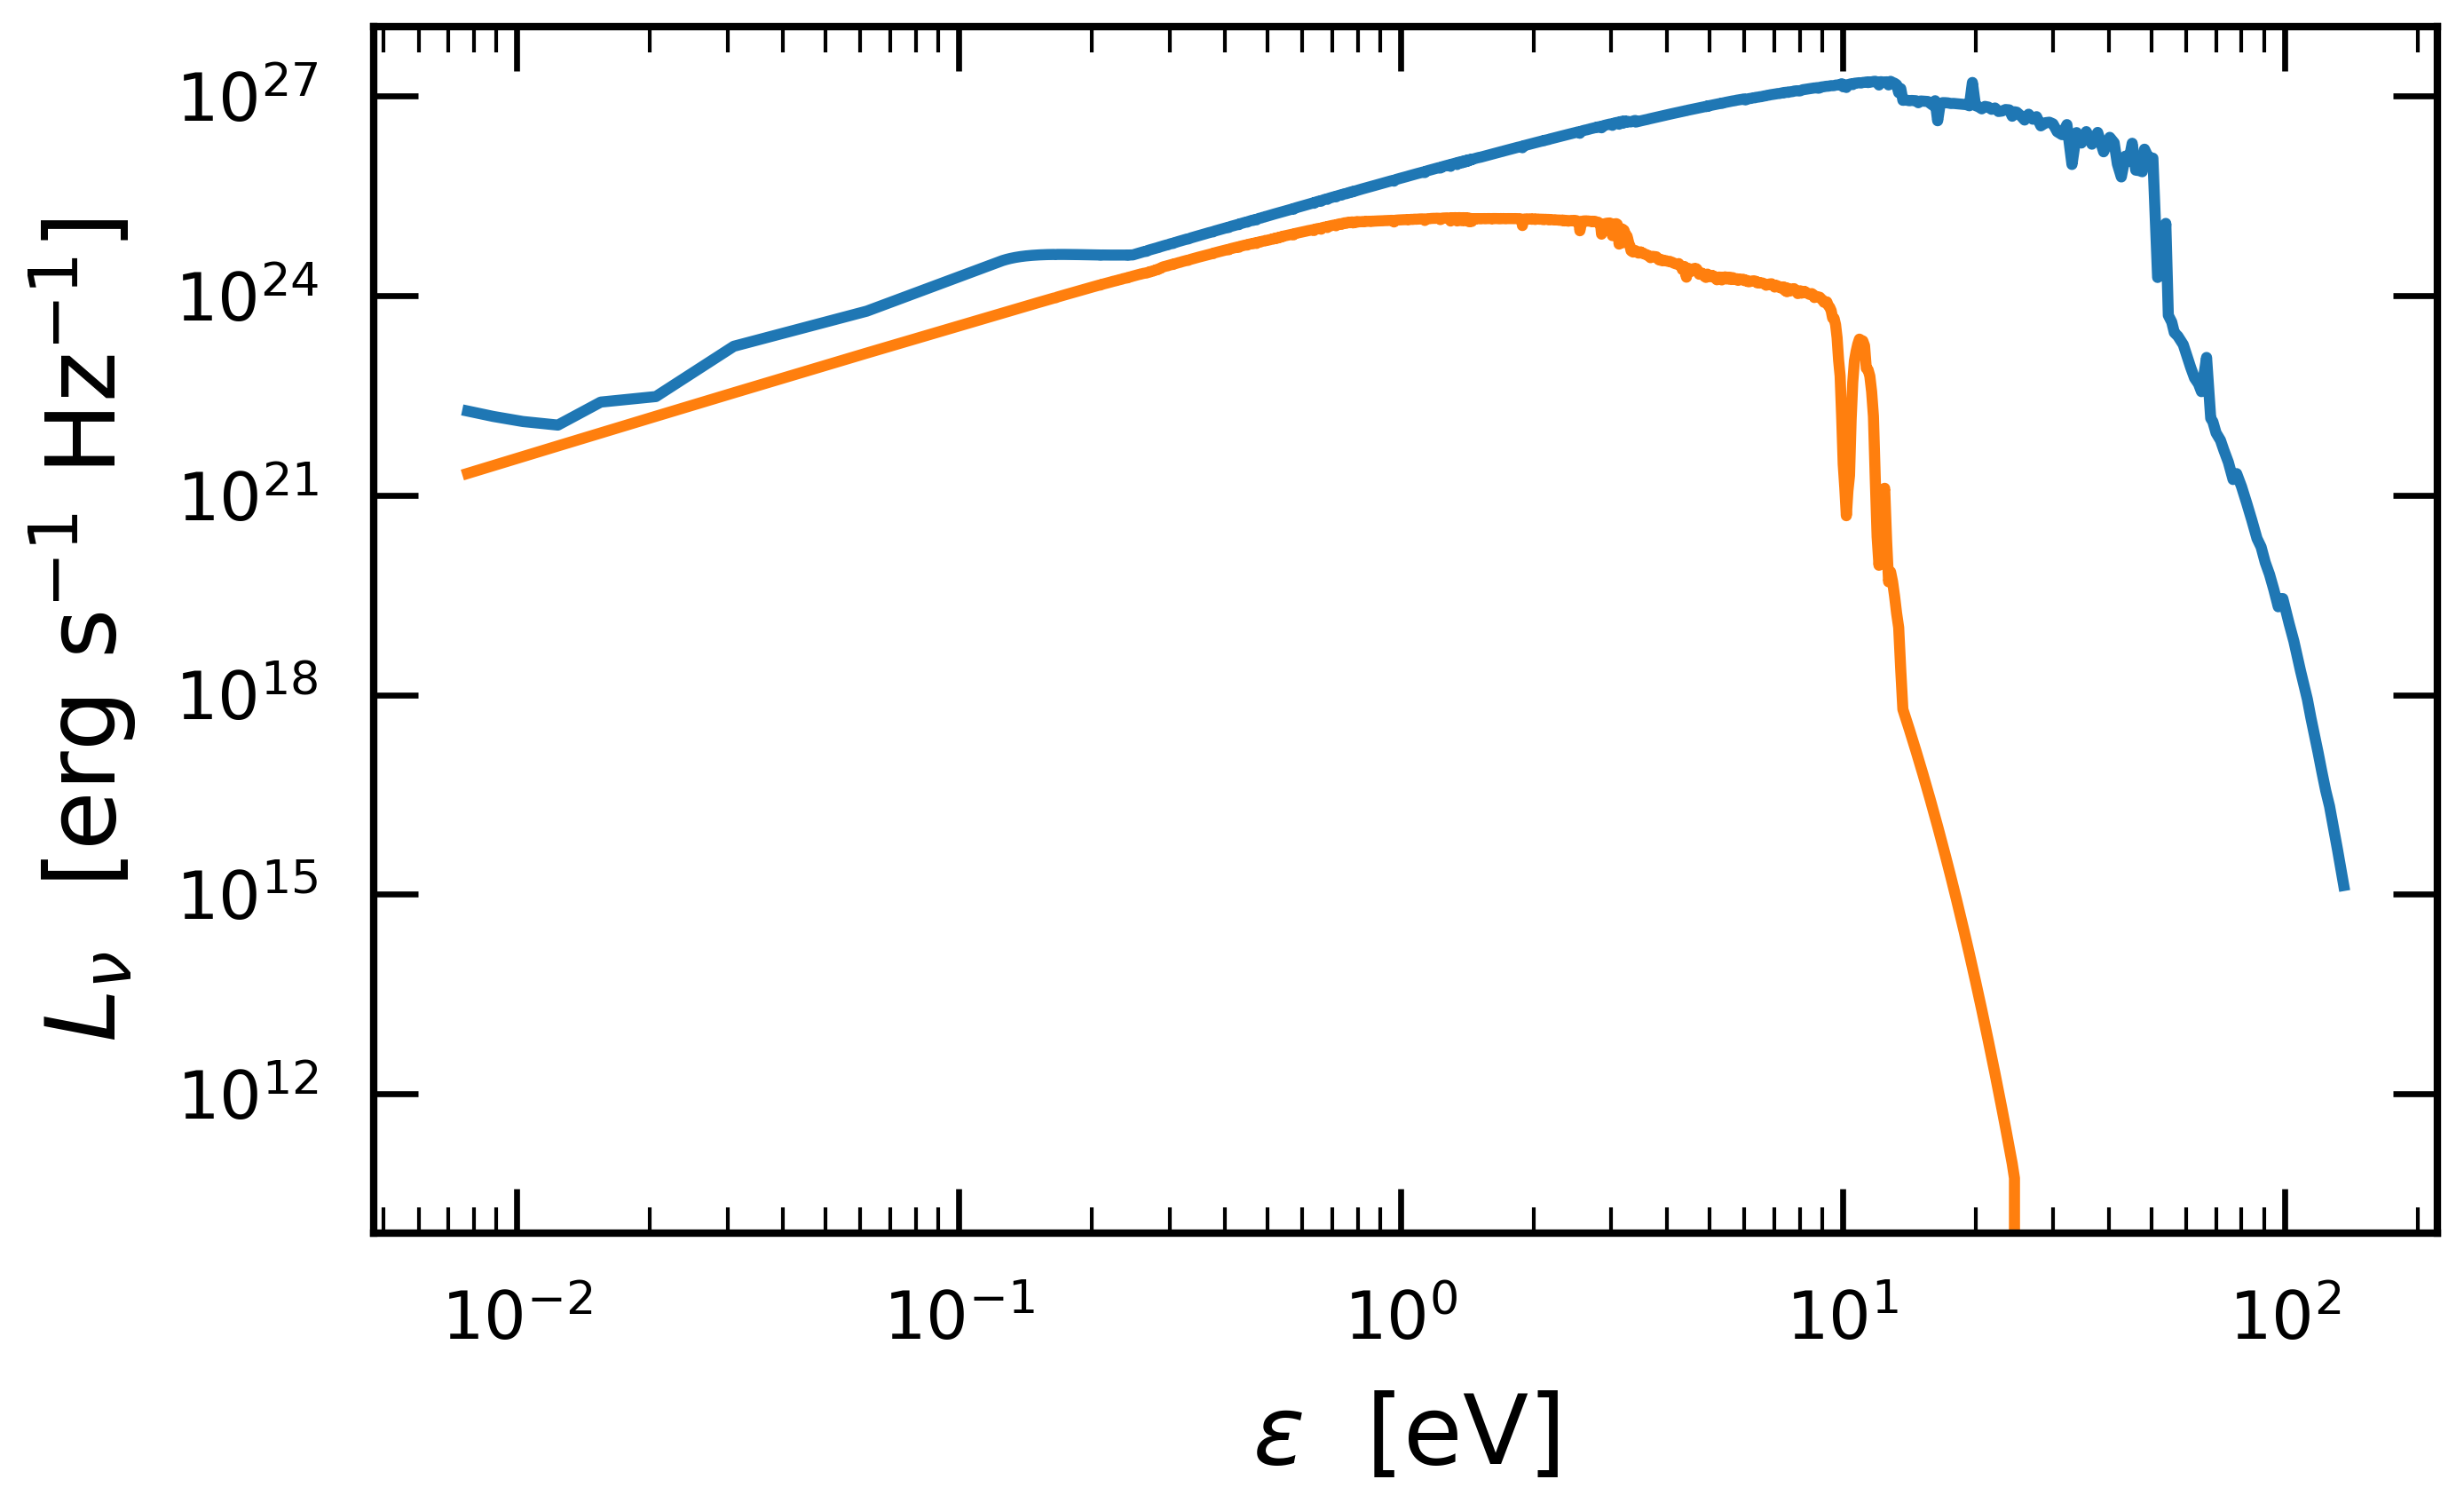

In [14]:
first_spectrum_freq = spec_lambda2nu(wl_SEDs, spectra_SEDs[0])
last_spectrum_freq = spec_lambda2nu(wl_SEDs, spectra_SEDs[-1])

fig, ax = plt.subplots()
ax.plot(energy_SEDs, first_spectrum_freq, lw=3)
ax.plot(energy_SEDs, last_spectrum_freq, lw=3)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\epsilon$  [eV]")
ax.set_ylabel(r"$L_\nu$  [$\mathrm{erg} \ \mathrm{s}^{-1} \ \mathrm{Hz}^{-1}$]")

In [ ]:
H2_diss_rate_slug, H2_heating_rate_slug = lwpr.compute_H2_diss_rate(
    wavelength_array=wl_SEDs,
    spectra_wl=spectra_SEDs,
    gas_density=gas_density_for_tests,
    gas_temperature=gas_temperature_for_tests,
    min_partition_function=1e-5,
    min_osc_strength_x_diss_fraction=1e-6
)

HM_detach_rate_slug = lwpr.compute_HM_detach_rate(
    wavelength_array=wl_SEDs,
    spectra_wl=spectra_SEDs
)

H2p_diss_rate_slug, H2p_heating_rate_slug = lwpr.compute_H2p_diss_rate(
    wavelength_array=wl_SEDs,
    spectra_wl=spectra_SEDs,
    gas_density=gas_density_for_tests,
    gas_temperature=gas_temperature_for_tests
)

/home/andrea/miniconda3/envs/env_py_3d6/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/andrea/miniconda3/envs/env_py_3d6/lib/python3.6/site-packages/frigus/solvers/linear.py:48: LinAlgWarning: Ill-conditioned matrix (rcond=9.93892e-27): result may not be accurate.
  C21 = scipy.linalg.solve(A22, A21)


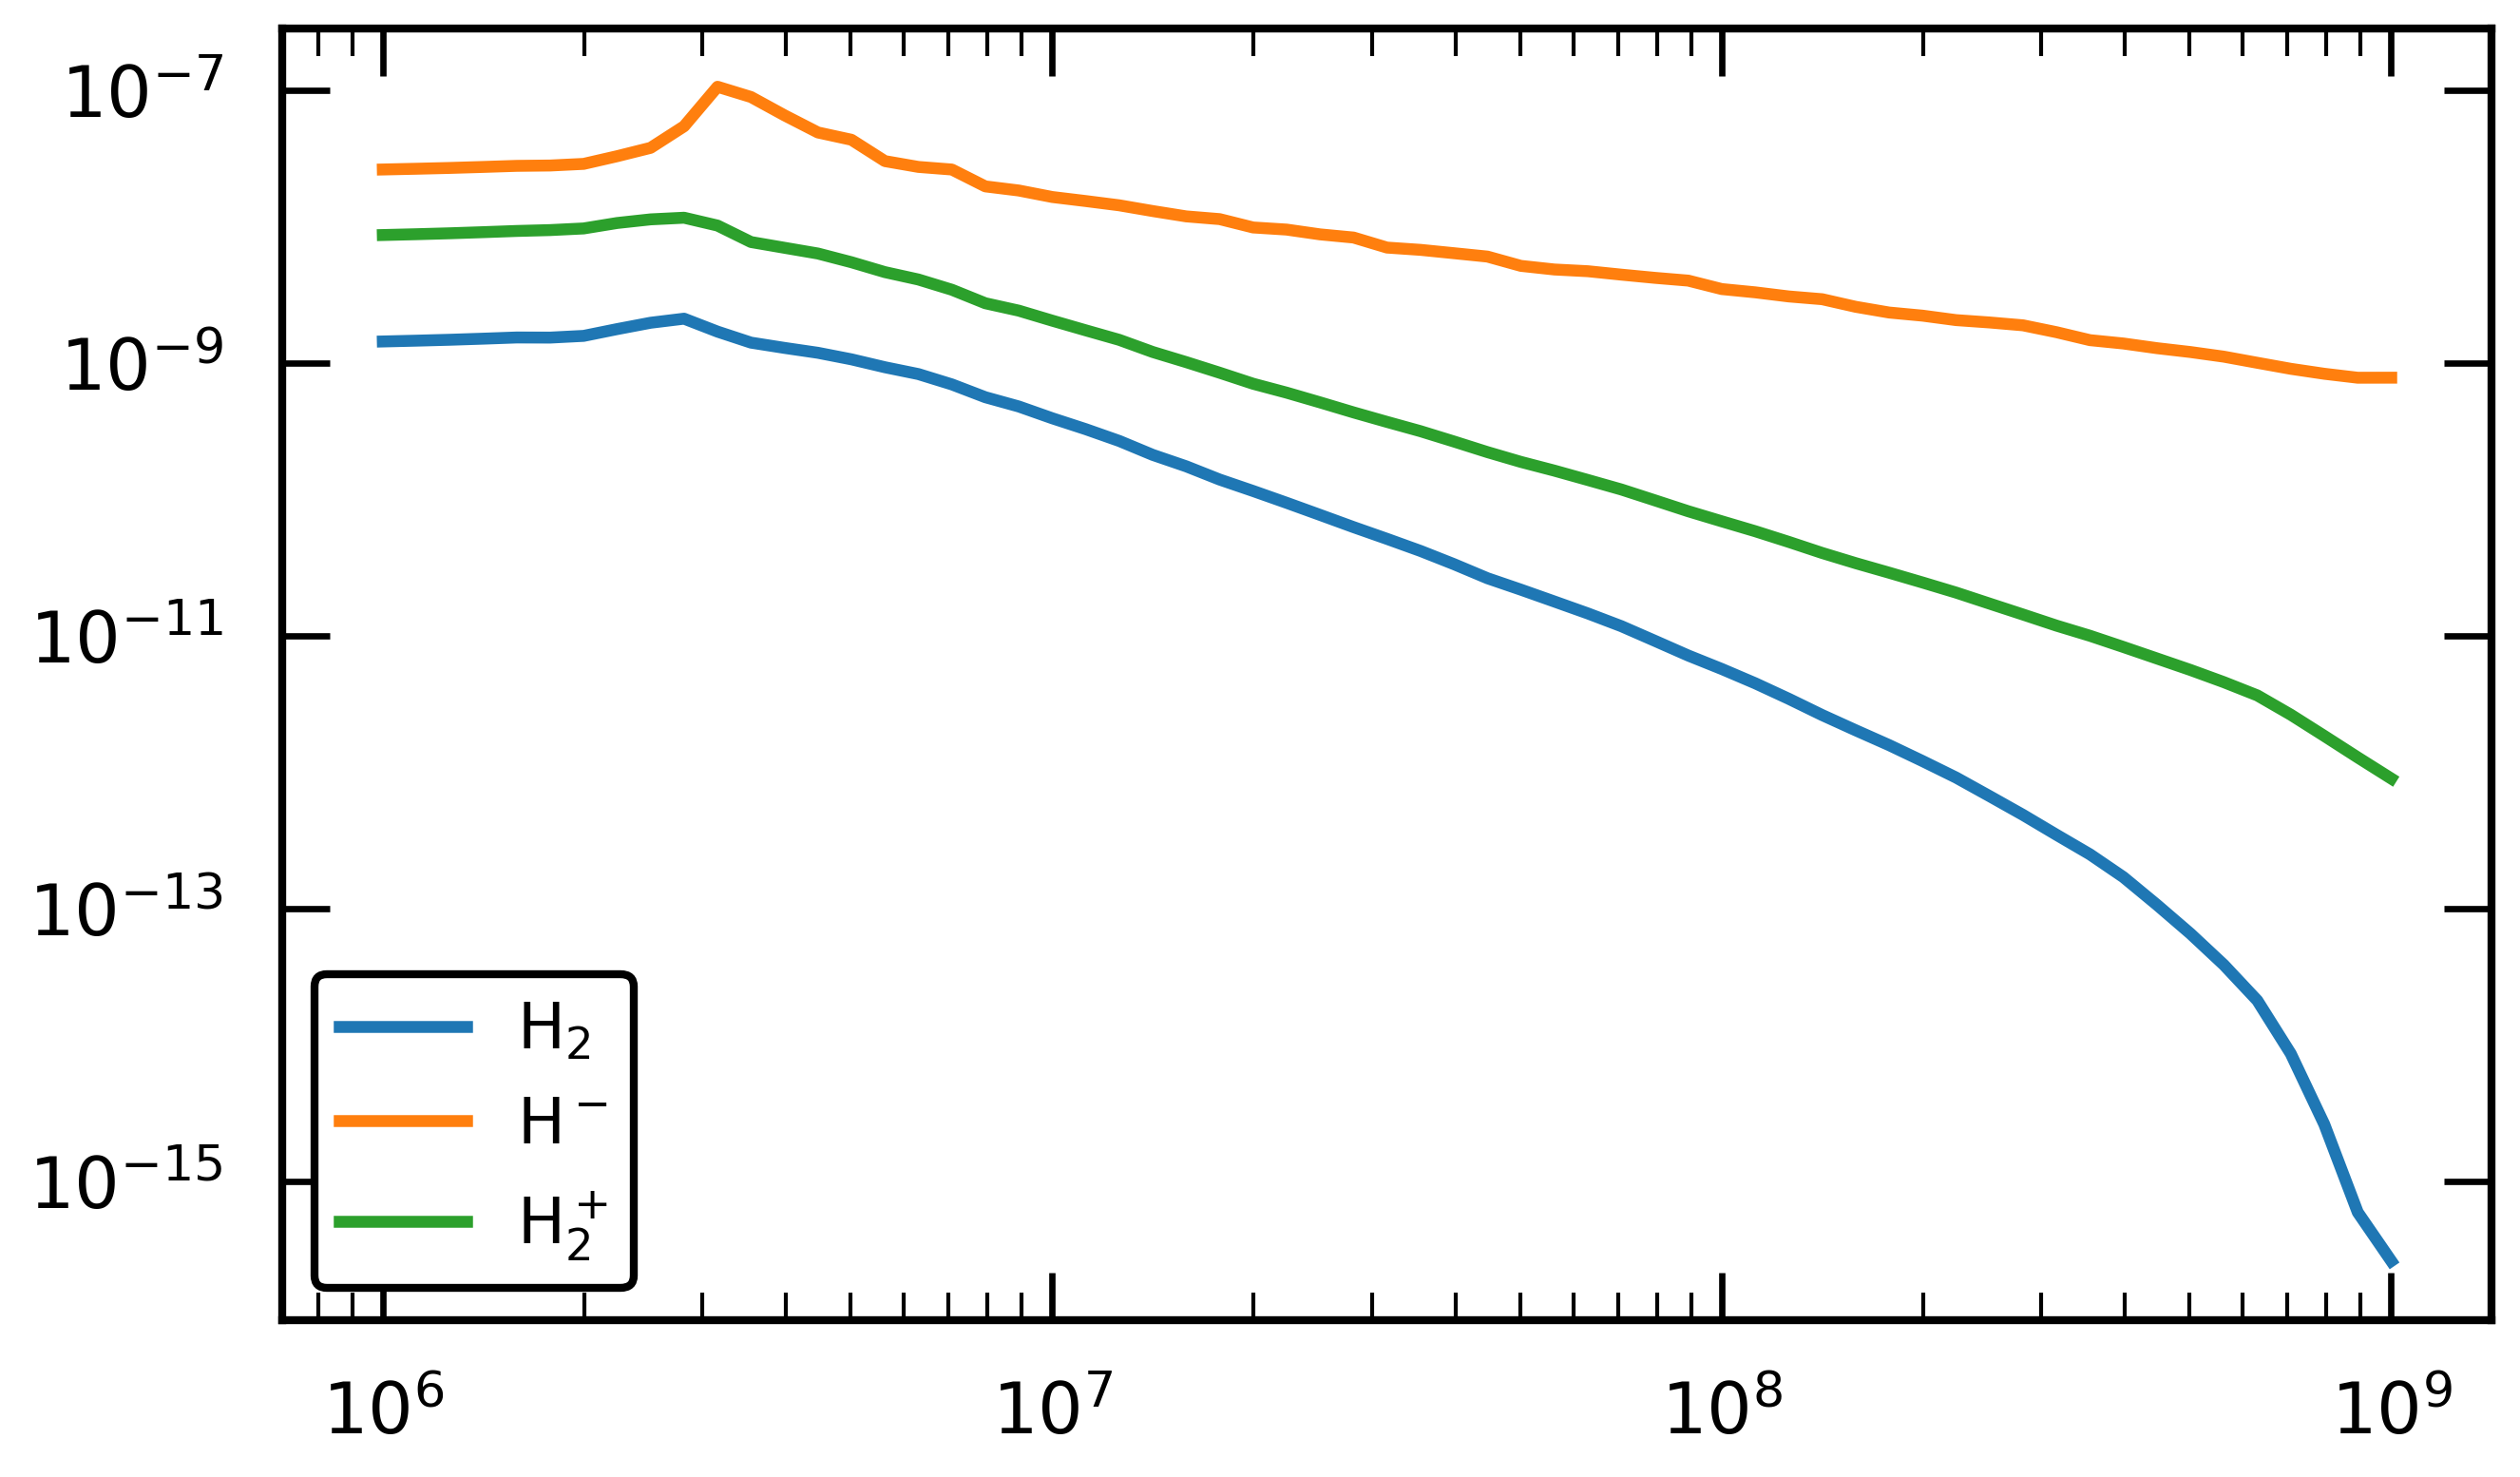

In [16]:
fig, ax = plt.subplots()
ax.plot(age_stars_SEDs, H2_diss_rate_slug, lw=3, label=r"$\mathrm{H}_2$")
ax.plot(age_stars_SEDs, HM_detach_rate_slug, lw=3, label=r"$\mathrm{H}^-$")
ax.plot(age_stars_SEDs, H2p_diss_rate_slug, lw=3, label=r"$\mathrm{H}^+_2$")
ax.set_xscale("log")
ax.set_yscale("log")
legend = ax.legend(ncol=1, loc="best")
legend.get_frame().set_linewidth(2)

# example: normalised black-body spectra
as in Latif+2015

## define black bodies

In [17]:
custom_energy_array = np.linspace(start=0.1, stop=13.6, num=int(1e4)) * u.eV
custom_frequency_array = custom_energy_array / const.h.to(u.eV / u.Hz)
custom_wavelength_array = nu2lambda(custom_frequency_array)

bb_spectra_array = np.empty(shape=(0, len(custom_wavelength_array)))

radiation_temperature_array = np.logspace(start=3.7, stop=5)
radiation_temperature_array = np.concatenate(([0.], radiation_temperature_array)) * u.K

# this gives a spherical surface of 1 cm^2
distance_for_tests = np.sqrt(1. / 4. / np.pi) * u.cm

for temperature in radiation_temperature_array:
    if temperature.value == 0:
        spectrum_freq = generate_flat_spectrum(spectrum_length=len(custom_energy_array)) * 1e-21 * 4. * np.pi * u.sr * u.cm**2
    else:
        spectrum_freq = generate_blackbody_spectrum(radiation_temperature=temperature, energy_array=custom_energy_array) * 1e-21 * 4. * np.pi * u.sr * u.cm**2
    spectrum_wl = spec_nu2lambda(custom_frequency_array, spectrum_freq)
    bb_spectra_array = np.vstack((bb_spectra_array, spectrum_wl))

## calculate rates

In [ ]:
H2_diss_rate, H2_heating_rate = lwpr.compute_H2_diss_rate(
    wavelength_array=custom_wavelength_array,
    spectra_wl=bb_spectra_array,
    distance=distance_for_tests.to(u.kpc),
    gas_density=gas_density_for_tests,
    gas_temperature=gas_temperature_for_tests,
    min_partition_function=1e-5,
    min_osc_strength_x_diss_fraction=1e-6
)

HM_detach_rate = lwpr.compute_HM_detach_rate(
    wavelength_array=custom_wavelength_array,
    spectra_wl=bb_spectra_array,
    distance=distance_for_tests.to(u.kpc)
)

H2p_diss_rate, H2p_heating_rate = lwpr.compute_H2p_diss_rate(
    wavelength_array=custom_wavelength_array,
    spectra_wl=bb_spectra_array,
    distance=distance_for_tests.to(u.kpc),
    gas_density=gas_density_for_tests,
    gas_temperature=gas_temperature_for_tests
)

/home/andrea/miniconda3/envs/env_py_3d6/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/andrea/miniconda3/envs/env_py_3d6/lib/python3.6/site-packages/frigus/solvers/linear.py:48: LinAlgWarning: Ill-conditioned matrix (rcond=9.93892e-27): result may not be accurate.
  C21 = scipy.linalg.solve(A22, A21)


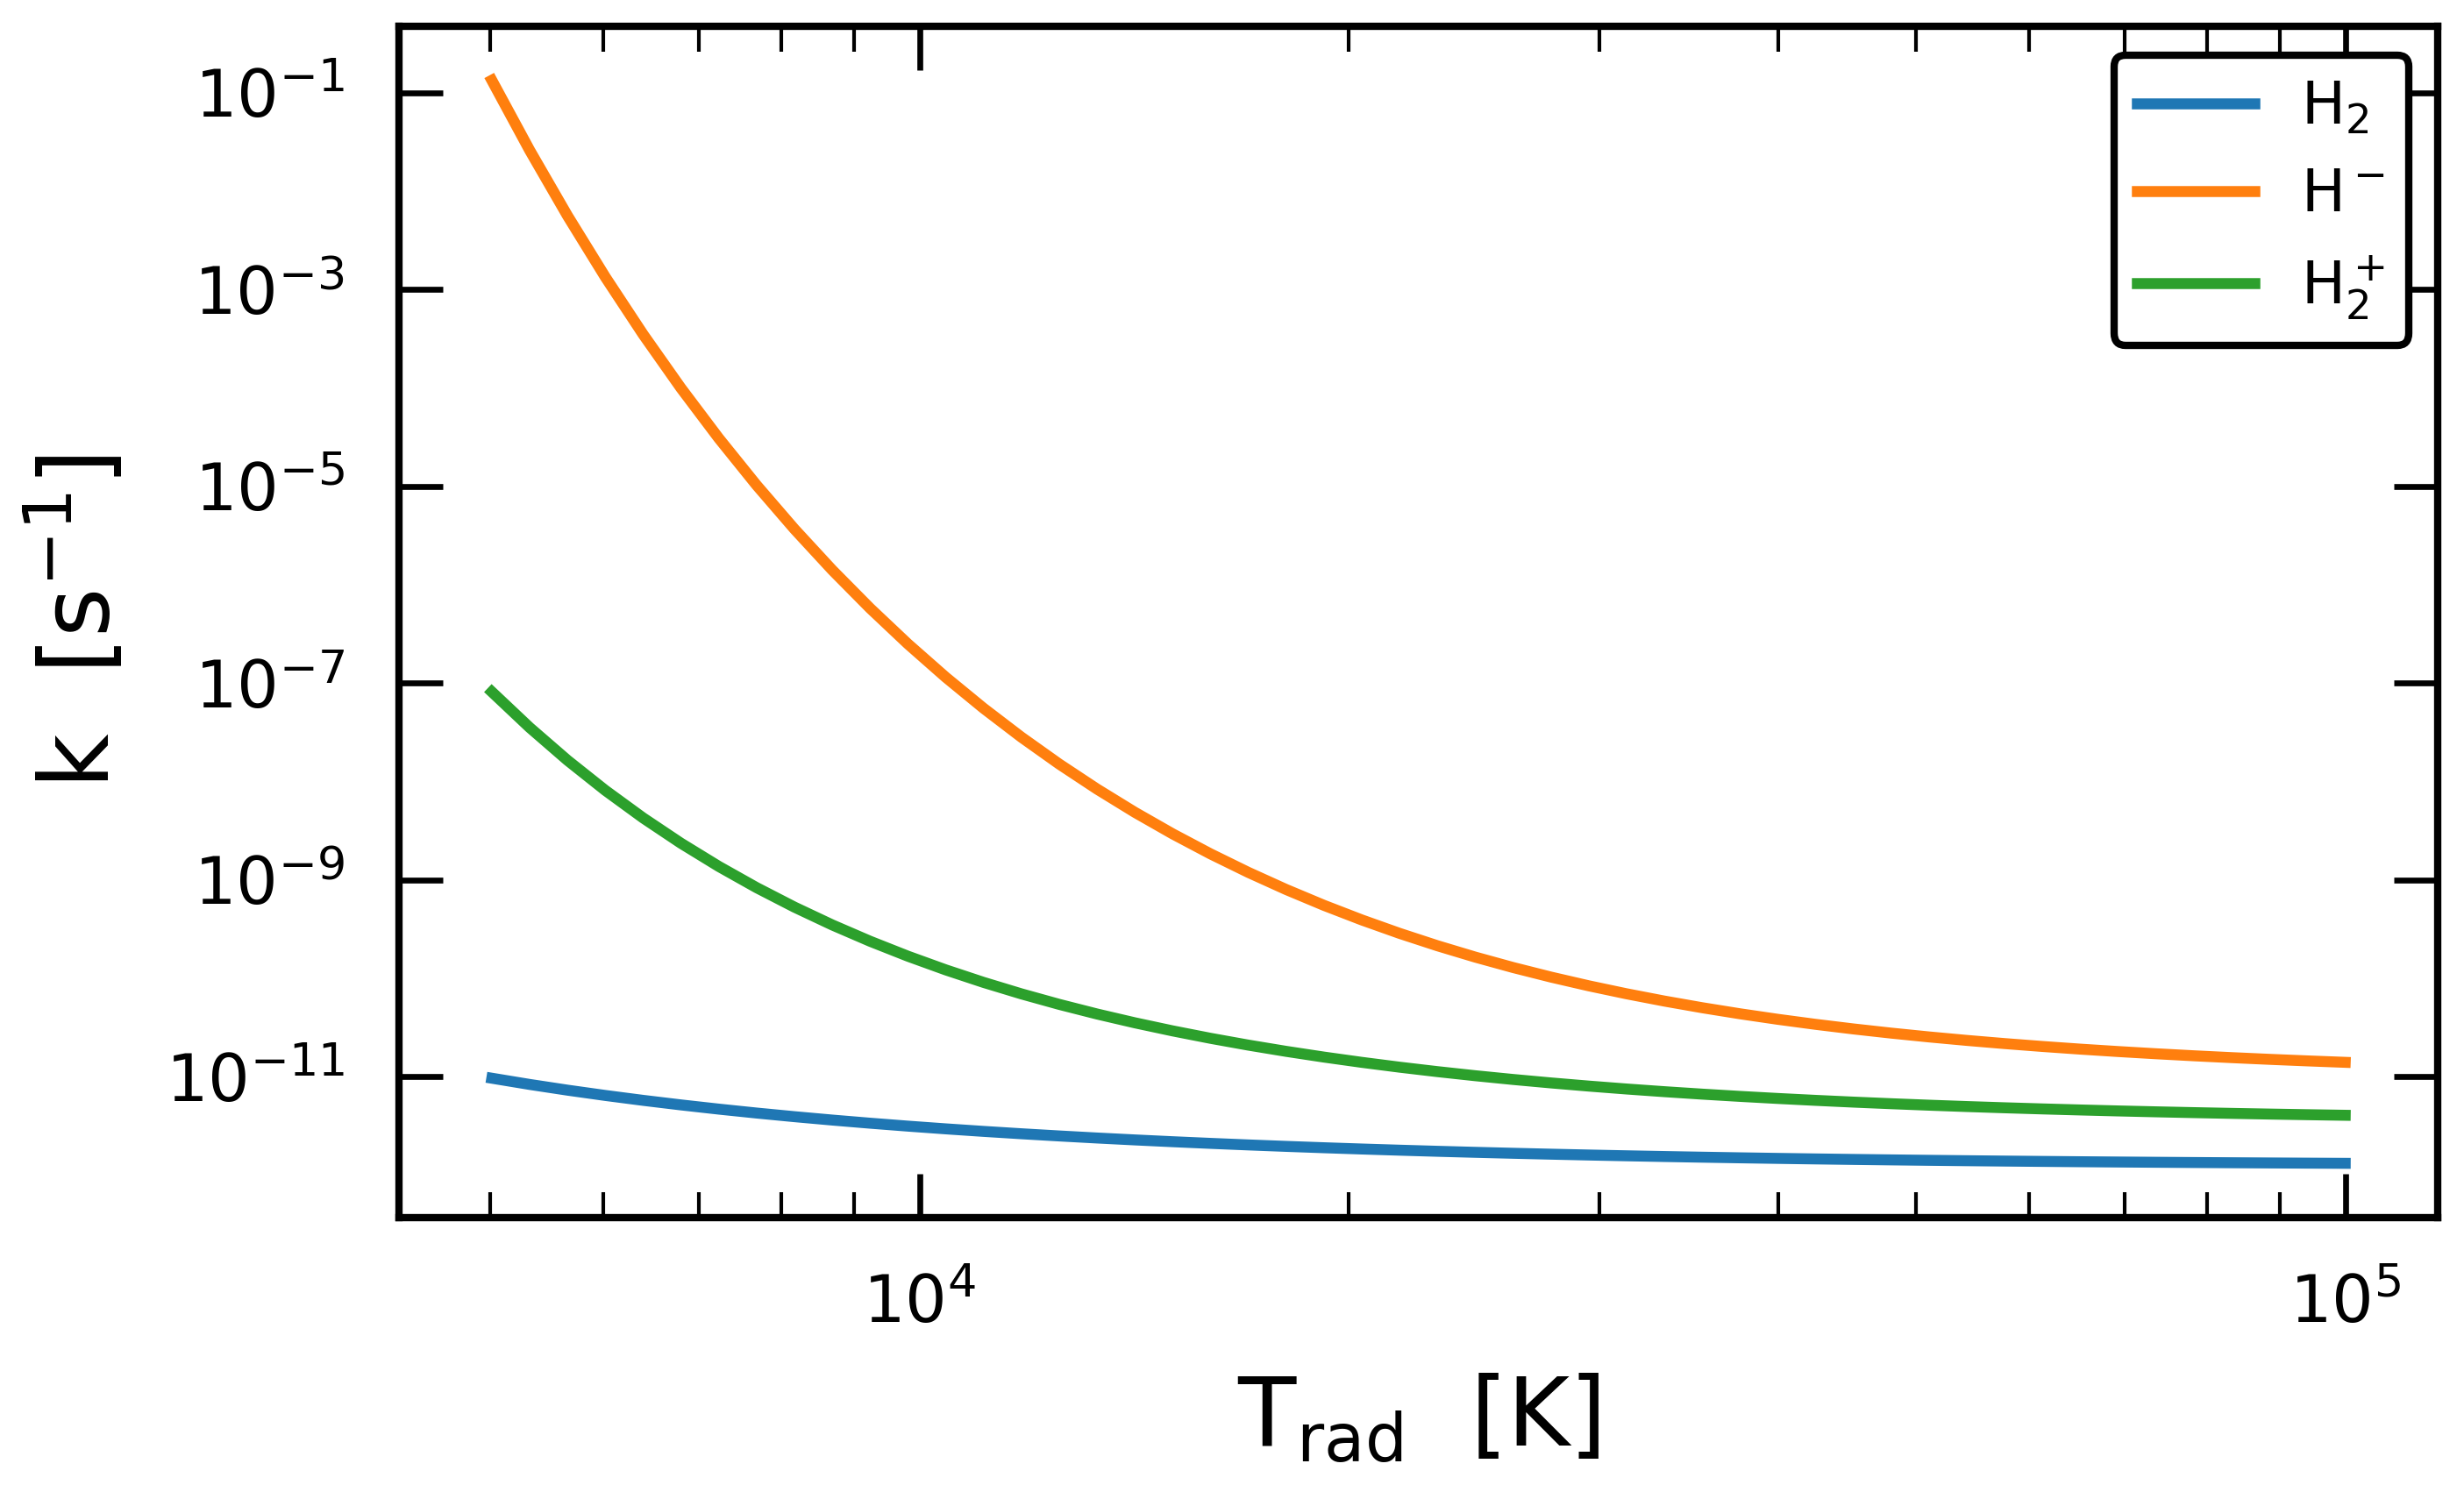

In [19]:
fig, ax = plt.subplots()
ax.plot(radiation_temperature_array[1:], H2_diss_rate[1:], lw=3, label=r"$\mathrm{H}_2$")
ax.plot(radiation_temperature_array[1:], HM_detach_rate[1:], lw=3, label=r"$\mathrm{H}^-$")
ax.plot(radiation_temperature_array[1:], H2p_diss_rate[1:], lw=3, label=r"$\mathrm{H}^+_2$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"T$_\mathrm{rad}$  [K]")
ax.set_ylabel(r"k  [s$^{-1}$]")
legend = ax.legend(ncol=1, loc="best")
legend.get_frame().set_linewidth(2)

## extrapolate fits

In [20]:
H2_fit_coeff0 = 1.1735e-1
H2_fit_coeff1 = 2.4958e-4
H2_fit_coeff2 = 3.4856e-9
H2_fit_coeff3 = 1.1902e1
H2_diss_fit = (H2_fit_coeff0 + H2_fit_coeff1 * radiation_temperature_array[1:].value + H2_fit_coeff2 * radiation_temperature_array[1:].value**2)**(-1.) - H2_fit_coeff3
H2_diss_fit = np.power(10., H2_diss_fit)

In [21]:
HM_fit_coeff0 = 9.08944e-2
HM_fit_coeff1 = 3.27940e-5
HM_fit_coeff2 = 5.98490e-1
HM_fit_coeff3 = 1.09867e1
HM_detach_fit = (HM_fit_coeff0 + HM_fit_coeff1 * radiation_temperature_array[1:].value)**(-1. / HM_fit_coeff2) - HM_fit_coeff3
HM_detach_fit = np.power(10., HM_detach_fit)

In [24]:
H2p_fit_coeff0 = 3.83012e6
H2p_fit_coeff1 = 5.06440e2
H2p_fit_coeff2 = 6.20988e-1
H2p_fit_coeff3 = 3.68778e-12
H2p_diss_fit = (-H2p_fit_coeff0 + H2p_fit_coeff1 * radiation_temperature_array[1:].value)**(-1. / H2p_fit_coeff2) + H2p_fit_coeff3

/home/andrea/miniconda3/envs/env_py_3d6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


In [22]:
from matplotlib.lines import Line2D
from matplotlib import legend as mlegend

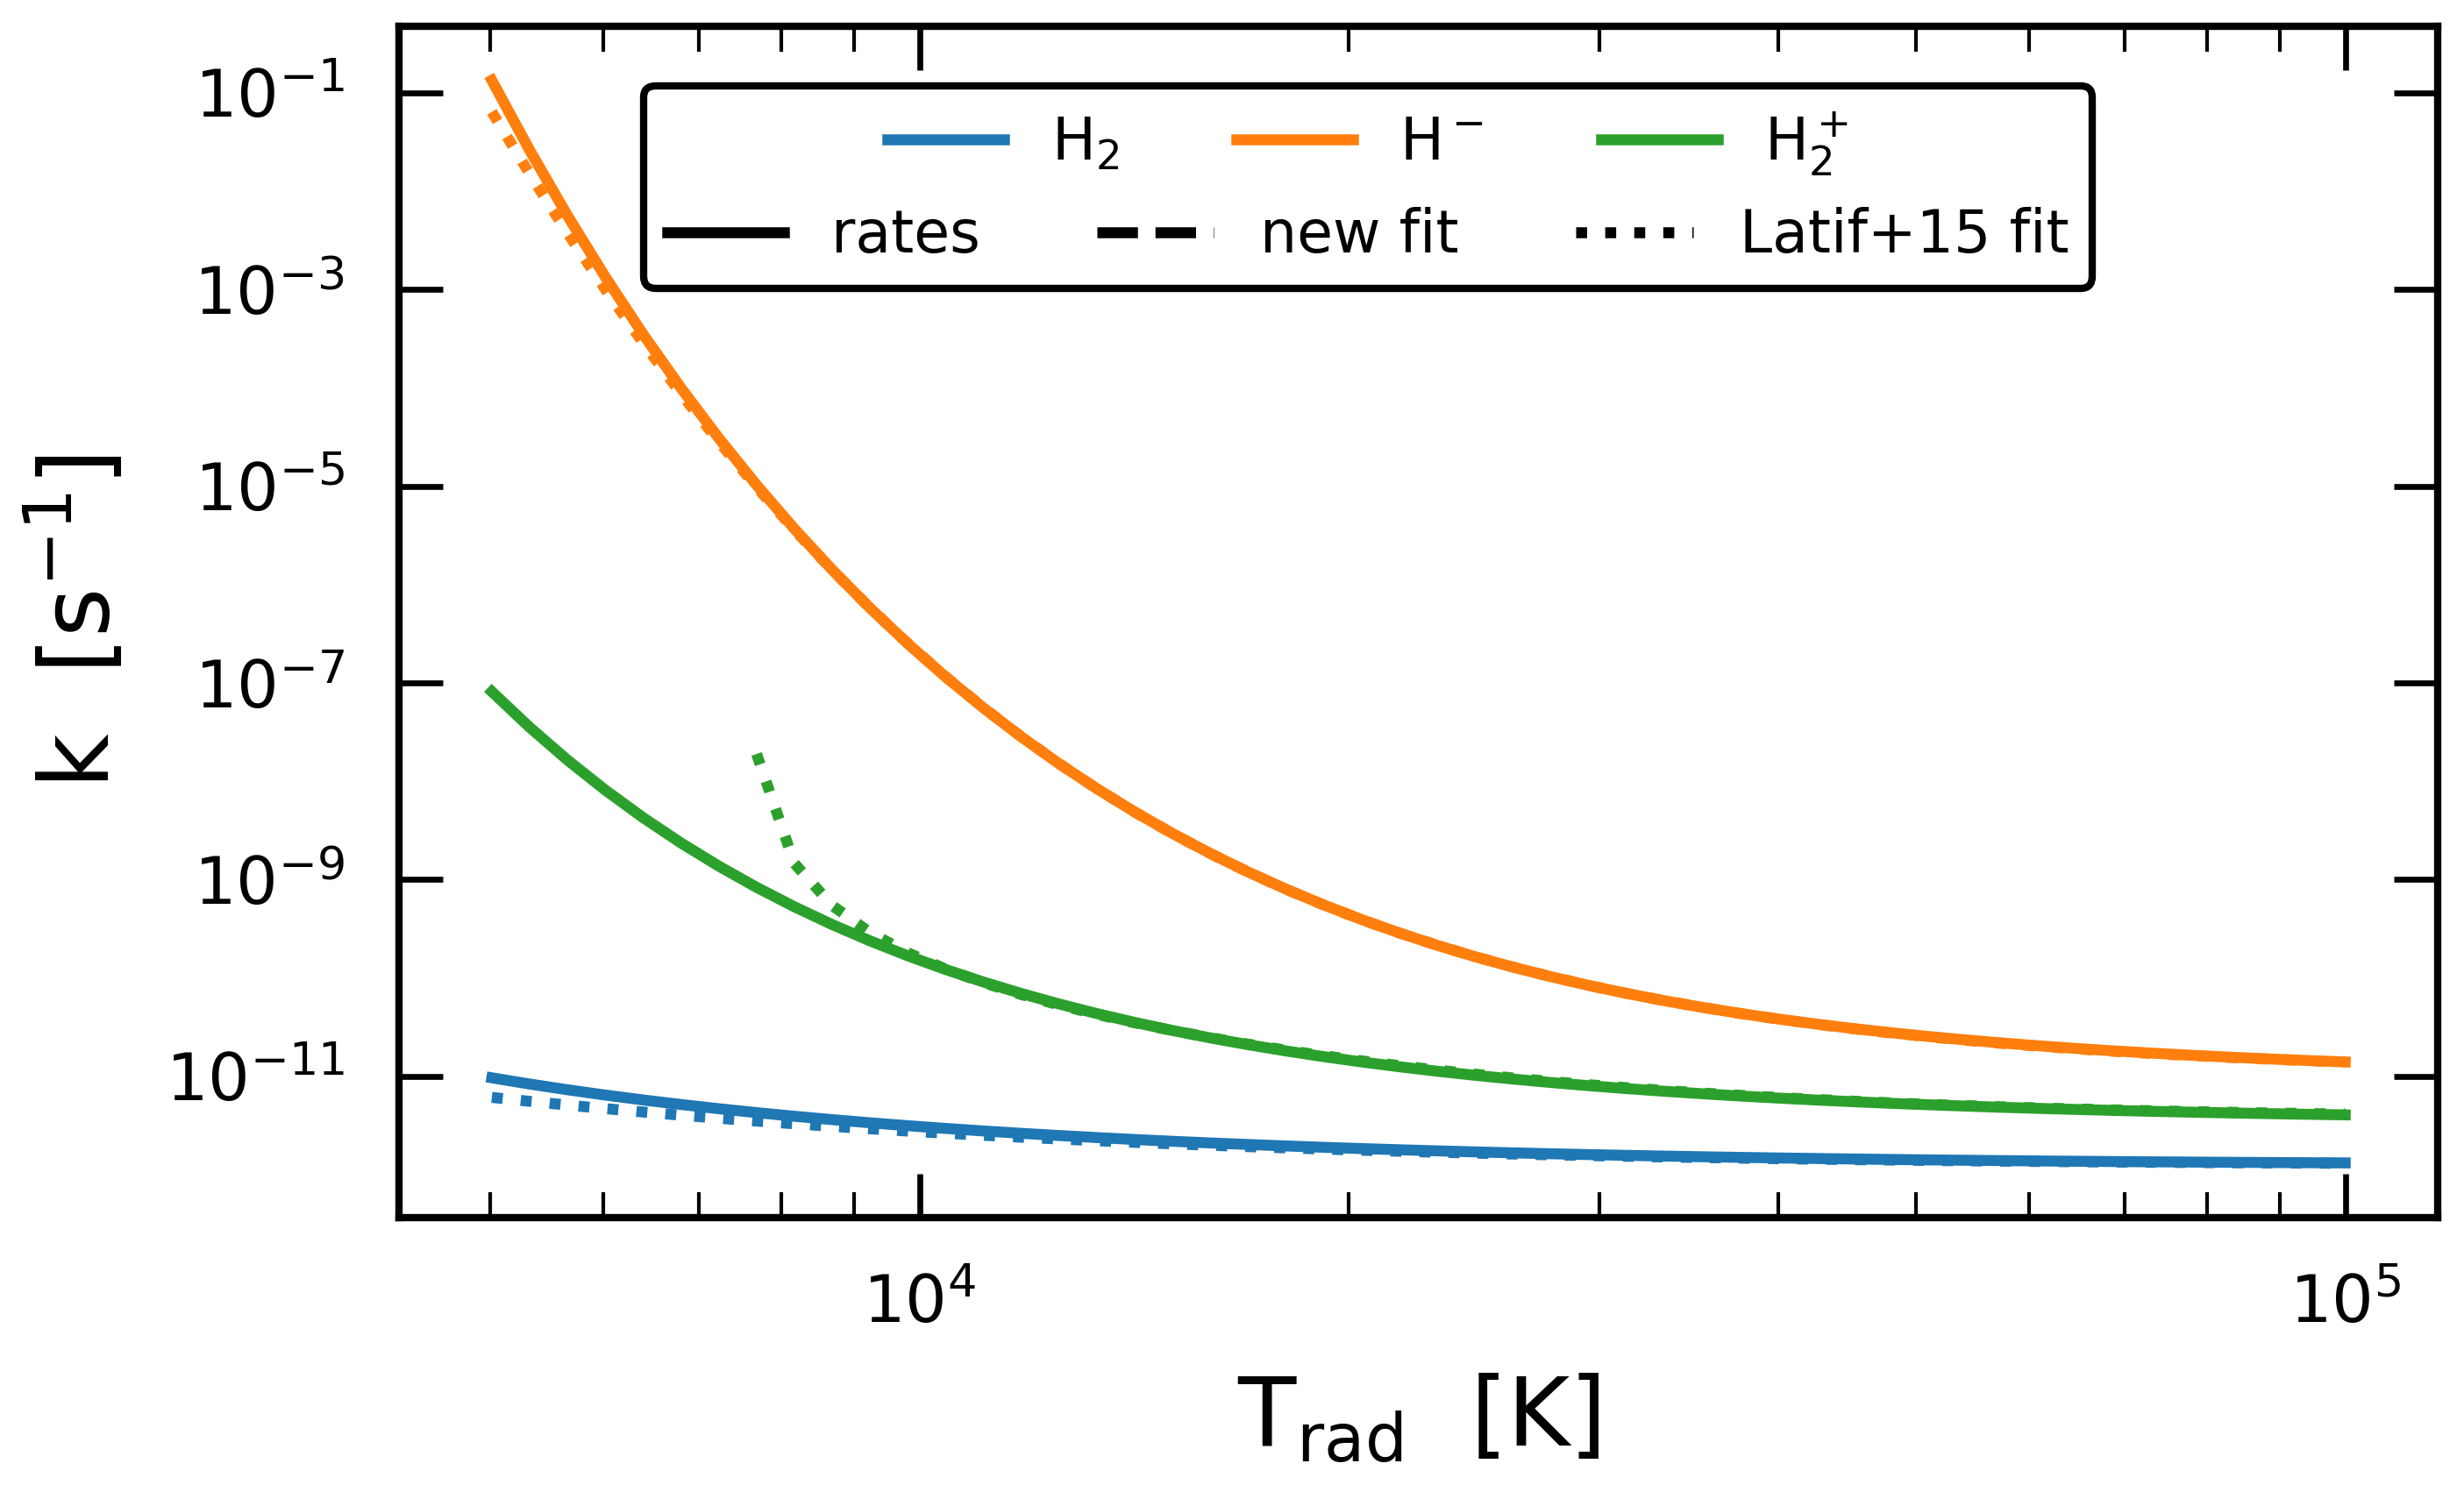

In [33]:
custom_lines1 = [Line2D([0], [0], c="C0", lw=3),
                 Line2D([0], [0], c="C1", lw=3),
                 Line2D([0], [0], c="C2", lw=3)]
custom_lines2 = [Line2D([0], [0], c="k", ls="-", lw=3),
                 Line2D([0], [0], c="k", ls="--",lw=3),
                 Line2D([0], [0], c="k", ls=":", lw=3)]
custom_labels1 = [r"$\mathrm{H}_2$", r"$\mathrm{H}^-$", r"$\mathrm{H}^+_2$"]
custom_labels2 = ["rates", "new fit", "Latif+15 fit"]


fig, ax = plt.subplots()

ax.plot(radiation_temperature_array[1:], H2_diss_rate[1:], lw=3, ls="-", c="C0")
ax.plot(radiation_temperature_array[1:], HM_detach_rate[1:], lw=3, ls="-", c="C1")
ax.plot(radiation_temperature_array[1:], H2p_diss_rate[1:], lw=3, ls="-", c="C2")

ax.plot(radiation_temperature_array[1:], H2_diss_fit, lw=3, ls=":", c="C0")
ax.plot(radiation_temperature_array[1:], HM_detach_fit, lw=3, ls=":", c="C1")
ax.plot(radiation_temperature_array[1:], H2p_diss_fit, lw=3, ls=":", c="C2")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"T$_\mathrm{rad}$  [K]")
ax.set_ylabel(r"k  [s$^{-1}$]")

leg1 = ax.legend(custom_lines1, custom_labels1, ncol=3, loc=(0.12, 0.78))
leg2 = mlegend.Legend(ax, custom_lines2, custom_labels2, ncol=3)
leg1._legend_box._children.append(leg2._legend_box._children[1])
leg1.get_frame().set_linewidth(2)

# example: flat spectrum

In [34]:
print(H2_diss_rate[0])
print(HM_detach_rate[0])
print(H2p_diss_rate[0])

1.3996909163151181e-12 1 / s
1.1024082847597092e-10 1 / s
5.30687768315465e-12 1 / s


# save rates for comparison

In [ ]:
import h5py

test_rates_file_path = os.path.join(os.getcwd(), "inputdata", "test_rates", "test_rates_initial_status.h5")
with h5py.File(test_rates_file_path, "w") as test_rates_file:
    test_rates_file.create_dataset(name="slug/H2", data=H2_diss_rate_slug)
    test_rates_file.create_dataset(name="slug/HM", data=HM_detach_rate_slug)
    test_rates_file.create_dataset(name="slug/H2p", data=H2p_diss_rate_slug)
    test_rates_file.create_dataset(name="slug/H2_heating", data=H2_heating_rate_slug)
    test_rates_file.create_dataset(name="slug/H2p_heating", data=H2p_heating_rate_slug)
    test_rates_file.create_dataset(name="slug/age_stars", data=age_stars_SEDs)
    test_rates_file.create_dataset(name="black_bodies/H2", data=H2_diss_rate[1:])
    test_rates_file.create_dataset(name="black_bodies/HM", data=HM_detach_rate[1:])
    test_rates_file.create_dataset(name="black_bodies/H2p", data=H2p_diss_rate[1:])
    test_rates_file.create_dataset(name="black_bodies/H2_heating", data=H2_heating_rate[1:])
    test_rates_file.create_dataset(name="black_bodies/H2p_heating", data=H2p_heating_rate[1:])
    test_rates_file.create_dataset(name="black_bodies/radiation_temperature", data=radiation_temperature_array[1:])
    test_rates_file.create_dataset(name="flat/H2", data=H2_diss_rate[0])
    test_rates_file.create_dataset(name="flat/HM", data=HM_detach_rate[0])
    test_rates_file.create_dataset(name="flat/H2p", data=H2p_diss_rate[0])
    test_rates_file.create_dataset(name="flat/H2_heating", data=H2_heating_rate[0])
    test_rates_file.create_dataset(name="flat/H2p_heating", data=H2p_heating_rate[0])

## random tests

H2p: GS vs LTE, Zammit vs Babb

In [35]:
gas_temperature_GS = 1e2 * u.K
gas_density_GS = 1e0 / u.cm**3

In [ ]:
gas_temperature_LTE = 5e3 * u.K

lwpr.H2p.calculate_critical_density(gas_temperature=gas_temperature_LTE)

<Quantity 696.53388515 1 / cm3>

In [37]:
gas_density_LTE = 1e4 / u.cm**3

In [ ]:
H2p_diss_rate_GS_B, H2p_heating_rate_GS_B = lwpr.compute_H2p_diss_rate(
    wavelength_array=custom_wavelength_array,
    spectra_wl=bb_spectra_array[0],
    distance=distance_for_tests.to(u.kpc),
    gas_density=gas_density_for_tests,
    gas_temperature=gas_temperature_for_tests,
    cross_section_reference="Z_17"
)

H2p_diss_rate_GS_Z, H2p_heating_rate_GS_Z = lwpr.compute_H2p_diss_rate(
    wavelength_array=custom_wavelength_array,
    spectra_wl=bb_spectra_array[0],
    distance=distance_for_tests.to(u.kpc),
    gas_density=gas_density_for_tests,
    gas_temperature=gas_temperature_for_tests,
    cross_section_reference="B_15"
)

H2p_diss_rate_LTE_B, H2p_heating_rate_LTE_B = lwpr.compute_H2p_diss_rate(
    wavelength_array=custom_wavelength_array,
    spectra_wl=bb_spectra_array[0],
    distance=distance_for_tests.to(u.kpc),
    gas_density=gas_density_LTE,
    gas_temperature=gas_temperature_LTE,
    cross_section_reference="Z_17"
)

H2p_diss_rate_LTE_Z, H2p_heating_rate_LTE_Z = lwpr.compute_H2p_diss_rate(
    wavelength_array=custom_wavelength_array,
    spectra_wl=bb_spectra_array[0],
    distance=distance_for_tests.to(u.kpc),
    gas_density=gas_density_LTE,
    gas_temperature=gas_temperature_LTE,
    cross_section_reference="B_15"
)

In [39]:
print("{0: >12}: \t {1}".format("GS - Babb", H2p_diss_rate_GS_B))
print("{0: >12}: \t {1}".format("LTE - Babb", H2p_diss_rate_LTE_B))
print("{0: >12}: \t {1}".format("GS - Zammit", H2p_diss_rate_GS_Z))
print("{0: >12}: \t {1}".format("LTE - Zammit", H2p_diss_rate_LTE_Z))

   GS - Babb: 	 5.30687768315465e-12 1 / s
  LTE - Babb: 	 9.332344028812605e-12 1 / s
 GS - Zammit: 	 5.310313929273745e-12 1 / s
LTE - Zammit: 	 7.951986464405937e-12 1 / s
